In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, classification_report, average_precision_score
from sklearn.preprocessing import StandardScaler

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import random_split
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as Data
from torchvision import datasets, transforms
torch.manual_seed(42) 

In [2]:
df = pd.read_csv("Churn_Modeling.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.shape

(10000, 14)

In [4]:
df.drop(['RowNumber','CustomerId'], axis=1, inplace=True)

In [5]:
target = 'Exited'

In [6]:
df[target].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

<b>20% for class 1. Is this meaans the data is imbalanced? According to one paper that I read, data is considered imbalanced if the lowest p is less than 15%. But Google has different opinion on this post: https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data. Let's explore on this.</b>

In [7]:
df.isnull().sum()

Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

<b>No empty values</b>

In [8]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [9]:
def show_mean_median(feature):   
    print('unique values:',feature.nunique())
    print('mean:',feature.mean())
    print('median:',feature.median())
    print('')
    
def show_values(df):
    for item in df.columns:
        print(item,'has',df[item].nunique(),'value(s)')
        print(df[item].value_counts(normalize=True))
        print('--------------------------------------')
        
def get_ohe_column_names(dic,feature):
    return [feature+'_'+str(k) for k,v in dic[feature].items() if v>0]        

# Feature Engineering

In [10]:
Surname = df['Surname'].value_counts().reset_index()

In [11]:
df = pd.merge(df,Surname, left_on='Surname', right_on='index', how='left')

In [12]:
df.rename(columns={'Surname_x':'Surname','Surname_y':'n_siblings'}, inplace=True)

In [13]:
df.drop(['index'], axis=1, inplace=True)

In [14]:
df['n_siblings'] = df['n_siblings']-1
df['has_siblings'] = np.where(df['n_siblings']>0,'Yes','No')

In [15]:
df.head()

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,n_siblings,has_siblings
0,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0,No
1,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,16,Yes
2,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,7,Yes
3,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,13,Yes
4,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,19,Yes


In [16]:
df.dtypes

Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
n_siblings           int64
has_siblings        object
dtype: object

In [17]:
categorical_features = []
numerical_features = []

for col,type_ in zip(df.columns,df.dtypes):
    
    if str(type_)=='object' and col!=target:        
        categorical_features.append(col)                
    elif col!=target:        
        numerical_features.append(col)

In [18]:
print('categorical_features:',categorical_features)
print('numerical_features:',numerical_features)

categorical_features: ['Surname', 'Geography', 'Gender', 'has_siblings']
numerical_features: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'n_siblings']


CreditScore :
unique values: 460
mean: 650.5288
median: 652.0



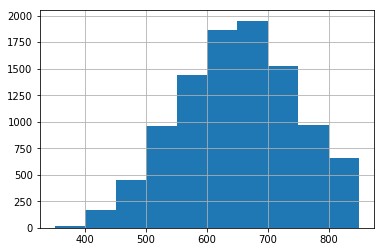

----------------
Age :
unique values: 70
mean: 38.9218
median: 37.0



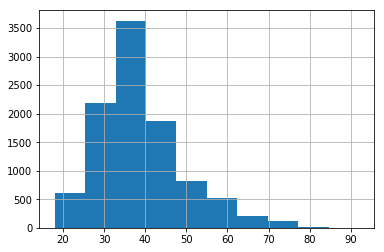

----------------
Tenure :
unique values: 11
mean: 5.0128
median: 5.0



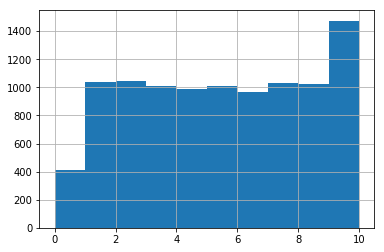

----------------
Balance :
unique values: 6382
mean: 76485.88928799961
median: 97198.54000000001



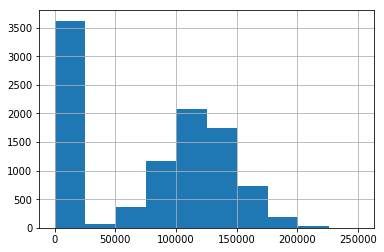

----------------
NumOfProducts :
unique values: 4
mean: 1.5302
median: 1.0



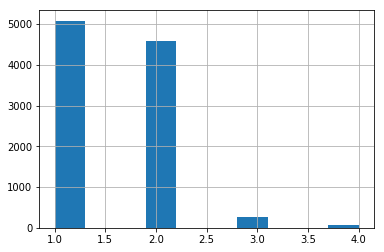

----------------
HasCrCard :
unique values: 2
mean: 0.7055
median: 1.0



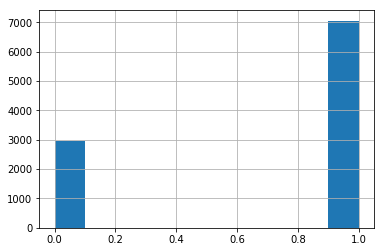

----------------
IsActiveMember :
unique values: 2
mean: 0.5151
median: 1.0



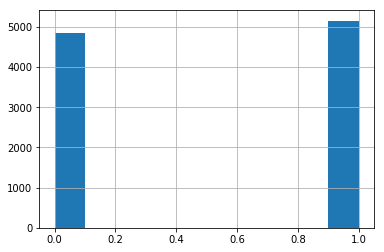

----------------
EstimatedSalary :
unique values: 9999
mean: 100090.2398809998
median: 100193.915



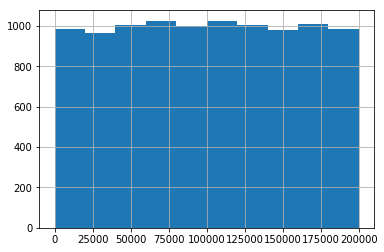

----------------
n_siblings :
unique values: 29
mean: 7.9702
median: 6.0



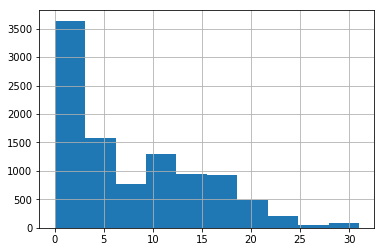

----------------


In [19]:
for col in numerical_features:
    if col!='RowNumber' and col!='CustomerId' and col!=target:        
        print(col,':')
        show_mean_median(df[col])
        df[col].hist()
        plt.show(block=False)
        print('----------------')
        
        

<b>Balance looks suspicious</b>

In [20]:
show_values(df[categorical_features])

Surname has 2932 value(s)
Smith         0.0032
Martin        0.0029
Scott         0.0029
Walker        0.0028
Brown         0.0026
               ...  
Eskridge      0.0001
Hirst         0.0001
Bluett        0.0001
Shoobridge    0.0001
Kepley        0.0001
Name: Surname, Length: 2932, dtype: float64
--------------------------------------
Geography has 3 value(s)
France     0.5014
Germany    0.2509
Spain      0.2477
Name: Geography, dtype: float64
--------------------------------------
Gender has 2 value(s)
Male      0.5457
Female    0.4543
Name: Gender, dtype: float64
--------------------------------------
has_siblings has 2 value(s)
Yes    0.8442
No     0.1558
Name: has_siblings, dtype: float64
--------------------------------------


# Data Manipulation

In [21]:
label_encoders = {}
one_hot_encoders = {} 
dic = {}
# scaler = {}

In [22]:
label_encoders[target] = LabelEncoder()        
df[target] = label_encoders[target].fit_transform(df[target])        

In [23]:
data = df.copy()

# 1st Trial: Use Surname as Feature

In [25]:
for col in categorical_features:
    
    if col!=target:                            
        
        label_encoders[col] = LabelEncoder()        
        data[col] = label_encoders[col].fit_transform(data[col])        
        dic[col] = dict(zip(label_encoders[col].classes_, label_encoders[col].transform(label_encoders[col].classes_)))
                                      
        one_hot_encoders[col] = OneHotEncoder(handle_unknown='ignore')
        one_hot_encoders[col].fit(data[col].values.reshape(-1,1))
        tmp = one_hot_encoders[col].transform(data[col].values.reshape(-1,1)).toarray()[:,1:]
        tmp_df = pd.DataFrame(tmp)
        tmp_df = pd.DataFrame(tmp, columns=get_ohe_column_names(dic,col))
        
        print(col,'gives',tmp_df.shape[1],'new feature(s)')
        
        data = pd.DataFrame(np.hstack([data,tmp_df]), columns=list(data.columns)+list(tmp_df.columns))
        
        del data[col]

Surname gives 2931 new feature(s)
Geography gives 2 new feature(s)
Gender gives 1 new feature(s)
has_siblings gives 1 new feature(s)


In [26]:
data = data.apply(pd.to_numeric)

In [27]:
feature_names = [col for col in data.columns if col!=target]

X = data[feature_names]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [28]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [29]:
y_pred = rf.predict(X_test)

In [30]:
print(confusion_matrix(y_test, y_pred))
print("Accuracy:",accuracy_score(y_test, y_pred))
print('AUC:',roc_auc_score(y_test,y_pred))
print('Precision:',precision_score(y_test,y_pred))
print('Average Precision Score:',average_precision_score(y_test, y_pred))
print('Recall:',recall_score(y_test,y_pred))
print('F1 Score:',f1_score(y_test,y_pred))

[[1568   39]
 [ 251  142]]
Accuracy: 0.855
AUC: 0.6685271656604138
Precision: 0.7845303867403315
Average Precision Score: 0.40896899470006887
Recall: 0.361323155216285
F1 Score: 0.49477351916376305


# 2nd Trial: Remove Surname feature

In [31]:
feature_names = [item for item in feature_names if 'Surname' not in item]

X = data[feature_names]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [32]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [33]:
y_pred = rf.predict(X_test)

In [34]:
print(confusion_matrix(y_test, y_pred))
print("Accuracy:",accuracy_score(y_test, y_pred))
print('AUC:',roc_auc_score(y_test,y_pred))
print('Precision:',precision_score(y_test,y_pred))
print('Average Precision Score:',average_precision_score(y_test, y_pred))
print('Recall:',recall_score(y_test,y_pred))
print('F1 Score:',f1_score(y_test,y_pred))

[[1549   58]
 [ 209  184]]
Accuracy: 0.8665
AUC: 0.7160506435743114
Precision: 0.7603305785123967
Average Precision Score: 0.46048174668264885
Recall: 0.4681933842239186
F1 Score: 0.5795275590551181


<b>At this point, model with more features performs worse than then model with less features.</b>

# 3rd Trial: Consider this data is imbalanced and keep Surname as feature

In [35]:
feature_names = [col for col in data.columns if col!=target]

X = data[feature_names]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [36]:
smote = SMOTE()
X_sm, y_sm = smote.fit_sample(X_train, y_train)

In [37]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_sm, y_sm)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [38]:
y_pred = rf.predict(X_test)

In [39]:
print(confusion_matrix(y_test, y_pred))
print("Accuracy:",accuracy_score(y_test, y_pred))
print('AUC:',roc_auc_score(y_test,y_pred))
print('Precision:',precision_score(y_test,y_pred))
print('Average Precision Score:',average_precision_score(y_test, y_pred))
print('Recall:',recall_score(y_test,y_pred))
print('F1 Score:',f1_score(y_test,y_pred))

[[1542   65]
 [ 229  164]]
Accuracy: 0.853
AUC: 0.6884273795782131
Precision: 0.7161572052401747
Average Precision Score: 0.41335440625798636
Recall: 0.4173027989821883
F1 Score: 0.5273311897106109


# 4th Trial: Consider this data is imbalanced and remove Surname as feature

In [40]:
feature_names = [item for item in feature_names if 'Surname' not in item]

X = data[feature_names]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [41]:
smote = SMOTE()
X_sm, y_sm = smote.fit_sample(X_train, y_train)

In [42]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_sm, y_sm)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [43]:
y_pred = rf.predict(X_test)

In [44]:
print(confusion_matrix(y_test, y_pred))
print("Accuracy:",accuracy_score(y_test, y_pred))
print('AUC:',roc_auc_score(y_test,y_pred))
print('Precision:',precision_score(y_test,y_pred))
print('Average Precision Score:',average_precision_score(y_test, y_pred))
print('Recall:',recall_score(y_test,y_pred))
print('F1 Score:',f1_score(y_test,y_pred))

[[1493  114]
 [ 173  220]]
Accuracy: 0.8565
AUC: 0.7444283992900019
Precision: 0.6586826347305389
Average Precision Score: 0.4552281924700218
Recall: 0.5597964376590331
F1 Score: 0.6052269601100412


# 5th Trial: Use ANN, keep Surname and consider this data is imbalanced

In [45]:
data = df.copy()

In [46]:
weights = list(data[target].value_counts(normalize=True).values)
weights_tensor = torch.tensor(weights)
weights_tensor

tensor([0.7963, 0.2037])

In [47]:
for col in categorical_features:
    
    if col!=target:                            
        
        label_encoders[col] = LabelEncoder()        
        data[col] = label_encoders[col].fit_transform(data[col])        
        dic[col] = dict(zip(label_encoders[col].classes_, label_encoders[col].transform(label_encoders[col].classes_)))                                      

In [48]:
data.head()

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,n_siblings,has_siblings
0,1115,619,0,0,42,2,0.00,1,1,1,101348.88,1,0,0
1,1177,608,2,0,41,1,83807.86,1,0,1,112542.58,0,16,1
2,2040,502,0,0,42,8,159660.80,3,1,0,113931.57,1,7,1
3,289,699,0,0,39,1,0.00,2,0,0,93826.63,0,13,1
4,1822,850,2,0,43,2,125510.82,1,1,1,79084.10,0,19,1


In [49]:
categorical_data = data[categorical_features].values
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)
# categorical_data[:10]

In [50]:
scaler = StandardScaler()        
scaled_features = scaler.fit_transform(data[numerical_features])
scaled_features = pd.DataFrame(scaled_features, columns=numerical_features)

In [51]:
numerical_data = np.stack([scaled_features[col].values for col in numerical_features], 1)
numerical_data = torch.tensor(numerical_data, dtype=torch.float)
# numerical_data[:5]

In [52]:
label_encoders[target] = LabelEncoder()        
data[target] = label_encoders[target].fit_transform(data[target])        

In [53]:
# outputs = torch.tensor(data[target], dtype=torch.int64)
# outputs[:5]

In [54]:
categorical_column_sizes = [data[column].nunique() for column in categorical_features]
print(categorical_column_sizes)
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]
print(categorical_embedding_sizes)

[2932, 3, 2, 2]
[(2932, 50), (3, 2), (2, 1), (2, 1)]


In [55]:
class Model(nn.Module):

    def __init__(self, embedding_size, num_numerical_cols, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        self.batch_norm_num = nn.BatchNorm1d(num_numerical_cols)

        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols + num_numerical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical, x_numerical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)

        x_numerical = self.batch_norm_num(x_numerical)
        x = torch.cat([x, x_numerical], 1)
        x = self.layers(x)
        return x

In [56]:
model = Model(categorical_embedding_sizes, numerical_data.shape[1], 2, [200,100,50], p=0.4)

In [57]:
model

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(2932, 50)
    (1): Embedding(3, 2)
    (2): Embedding(2, 1)
    (3): Embedding(2, 1)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (batch_norm_num): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=63, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_f

In [58]:
feature_names = [item for item in data.columns if item!=target]

X = data[feature_names]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [59]:
loss_function = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [60]:
epochs = 500
aggregated_losses = []

for i in range(epochs):
    i += 1
    
    categorical_train_data = torch.tensor(X_train[categorical_features].values, dtype=torch.int64)
    numerical_train_data = torch.tensor(X_train[numerical_features].values, dtype=torch.float) 
    
    y_pred = model(categorical_train_data, numerical_train_data)
    
    train_outputs = torch.tensor(y_train.values, dtype=torch.int64)
    
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss)

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.77360153
epoch:  26 loss: 0.61217183
epoch:  51 loss: 0.54679930
epoch:  76 loss: 0.47763988
epoch: 101 loss: 0.38686088
epoch: 126 loss: 0.30817536
epoch: 151 loss: 0.24544770
epoch: 176 loss: 0.21727952
epoch: 201 loss: 0.20444484
epoch: 226 loss: 0.19209541
epoch: 251 loss: 0.18173657
epoch: 276 loss: 0.17764281
epoch: 301 loss: 0.17471237
epoch: 326 loss: 0.17088942
epoch: 351 loss: 0.16176184
epoch: 376 loss: 0.16406086
epoch: 401 loss: 0.15733083
epoch: 426 loss: 0.15743265
epoch: 451 loss: 0.15259312
epoch: 476 loss: 0.15091997
epoch: 500 loss: 0.1486848444


In [61]:
with torch.no_grad():
    
    categorical_test_data = torch.tensor(X_test[categorical_features].values, dtype=torch.int64)
    numerical_test_data = torch.tensor(X_test[numerical_features].values, dtype=torch.float)     
    y_val = model(categorical_test_data, numerical_test_data)
    
    test_outputs = torch.tensor(y_test.values, dtype=torch.int64)
    
    loss = loss_function(y_val, test_outputs)
print(f'Loss: {loss:.8f}')

Loss: 0.20139115


In [62]:
y_val = np.argmax(y_val, axis=1)

In [64]:
print(classification_report(test_outputs,y_val))

print(confusion_matrix(test_outputs,y_val))
print("Accuracy:",accuracy_score(test_outputs,y_val))
print('AUC:',roc_auc_score(test_outputs,y_val))
print('Precision:',precision_score(test_outputs,y_val))
print('Average Precision Score:',average_precision_score(test_outputs,y_val))
print('Recall:',recall_score(test_outputs,y_val))
print('F1 Score:',f1_score(test_outputs,y_val))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91      1607
           1       0.81      0.30      0.44       393

    accuracy                           0.85      2000
   macro avg       0.83      0.64      0.68      2000
weighted avg       0.84      0.85      0.82      2000

[[1579   28]
 [ 275  118]]
Accuracy: 0.8485
AUC: 0.641415340962171
Precision: 0.8082191780821918
Average Precision Score: 0.38017140715953857
Recall: 0.30025445292620867
F1 Score: 0.437847866419295


# 6th Trial: Use ANN, remove Surname and consider this data is imbalanced

In [67]:
categorical_column_sizes = [data[column].nunique() for column in categorical_features if column!='Surname']
print(categorical_column_sizes)
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]
print(categorical_embedding_sizes)

[3, 2, 2]
[(3, 2), (2, 1), (2, 1)]


In [68]:
model = Model(categorical_embedding_sizes, numerical_data.shape[1], 2, [200,100,50], p=0.4)

In [69]:
feature_names = [item for item in data.columns if item!=target and item!='Surname']

X = data[feature_names]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [71]:
loss_function = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [75]:
categorical_features.remove('Surname')
categorical_features

['Geography', 'Gender', 'has_siblings']

In [76]:
epochs = 500
aggregated_losses = []

for i in range(epochs):
    i += 1
    
    categorical_train_data = torch.tensor(X_train[categorical_features].values, dtype=torch.int64)
    numerical_train_data = torch.tensor(X_train[numerical_features].values, dtype=torch.float) 
    
    y_pred = model(categorical_train_data, numerical_train_data)
    
    train_outputs = torch.tensor(y_train.values, dtype=torch.int64)
    
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss)

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.80671388
epoch:  26 loss: 0.56872594
epoch:  51 loss: 0.47079441
epoch:  76 loss: 0.37534502
epoch: 101 loss: 0.29864141
epoch: 126 loss: 0.24269298
epoch: 151 loss: 0.20871542
epoch: 176 loss: 0.18559323
epoch: 201 loss: 0.18629253
epoch: 226 loss: 0.18171649
epoch: 251 loss: 0.17779107
epoch: 276 loss: 0.17644633
epoch: 301 loss: 0.17456865
epoch: 326 loss: 0.16886547
epoch: 351 loss: 0.17122710
epoch: 376 loss: 0.16912745
epoch: 401 loss: 0.16805752
epoch: 426 loss: 0.16925465
epoch: 451 loss: 0.16828926
epoch: 476 loss: 0.16485825
epoch: 500 loss: 0.1670506895


In [77]:
with torch.no_grad():
    
    categorical_test_data = torch.tensor(X_test[categorical_features].values, dtype=torch.int64)
    numerical_test_data = torch.tensor(X_test[numerical_features].values, dtype=torch.float)     
    y_val = model(categorical_test_data, numerical_test_data)
    
    test_outputs = torch.tensor(y_test.values, dtype=torch.int64)
    
    loss = loss_function(y_val, test_outputs)
print(f'Loss: {loss:.8f}')

Loss: 0.17407529


In [78]:
y_val = np.argmax(y_val, axis=1)

In [79]:
print(classification_report(test_outputs,y_val))

print(confusion_matrix(test_outputs,y_val))
print("Accuracy:",accuracy_score(test_outputs,y_val))
print('AUC:',roc_auc_score(test_outputs,y_val))
print('Precision:',precision_score(test_outputs,y_val))
print('Average Precision Score:',average_precision_score(test_outputs,y_val))
print('Recall:',recall_score(test_outputs,y_val))
print('F1 Score:',f1_score(test_outputs,y_val))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      1607
           1       0.87      0.25      0.38       393

    accuracy                           0.84      2000
   macro avg       0.86      0.62      0.65      2000
weighted avg       0.85      0.84      0.81      2000

[[1593   14]
 [ 296   97]]
Accuracy: 0.845
AUC: 0.6190537264607292
Precision: 0.8738738738738738
Average Precision Score: 0.36368897141416223
Recall: 0.24681933842239187
F1 Score: 0.384920634920635


So which one to use? This exercise gives you 6 model with different combination features and techniques. For sure, this is imbalanced data case so you might want to consider to choose model that accomodate imbalanced data. Next, should <b>Surname</b> included as a feature? Well, it depend on your metric that you want to use to evalute the model. Remove <b>Surname</b> as a feature always gives better AUC score unless for ANN. So, the decision is on your side.